In [3]:
# %% [markdown]
# # F1 Naive Bayes Analysis
# This notebook uses FastF1 to fetch Formula 1 race data, 
# cleans it, builds a dataset, applies Naive Bayes classification, 
# and draws conclusions with probabilities.

# %%
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Config: Race to analyze
RACE_YEAR = 2023
RACE_GP = "Bahrain"
RACE_TYPE = "R"

# Hide FastF1 logging
import logging
logging.getLogger("fastf1").setLevel(logging.WARNING)


In [4]:
# %%
session = fastf1.get_session(RACE_YEAR, RACE_GP, RACE_TYPE)
session.load()

laps = session.laps
weather = session.weather_data

print(f"Loaded {len(laps)} laps for {RACE_YEAR} {RACE_GP} GP")
laps.head()


Loaded 1056 laps for 2023 Bahrain GP


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:04:15.902000,VER,1,0 days 00:01:39.019000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:42.414000,...,False,Red Bull Racing,0 days 01:02:36.652000,2023-03-05 15:03:38.501,12,1.0,False,,False,False
1,0 days 01:05:53.876000,VER,1,0 days 00:01:37.974000,2.0,1.0,NaT,NaT,0 days 00:00:31.342000,0 days 00:00:42.504000,...,False,Red Bull Racing,0 days 01:04:15.902000,2023-03-05 15:05:17.751,12,1.0,False,,False,True
2,0 days 01:07:31.882000,VER,1,0 days 00:01:38.006000,3.0,1.0,NaT,NaT,0 days 00:00:31.388000,0 days 00:00:42.469000,...,False,Red Bull Racing,0 days 01:05:53.876000,2023-03-05 15:06:55.725,1,1.0,False,,False,True
3,0 days 01:09:09.858000,VER,1,0 days 00:01:37.976000,4.0,1.0,NaT,NaT,0 days 00:00:31.271000,0 days 00:00:42.642000,...,False,Red Bull Racing,0 days 01:07:31.882000,2023-03-05 15:08:33.731,1,1.0,False,,False,True
4,0 days 01:10:47.893000,VER,1,0 days 00:01:38.035000,5.0,1.0,NaT,NaT,0 days 00:00:31.244000,0 days 00:00:42.724000,...,False,Red Bull Racing,0 days 01:09:09.858000,2023-03-05 15:10:11.707,1,1.0,False,,False,True


In [5]:
# %%
# Keep numeric features
features = ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time",
            "SpeedI1", "SpeedI2", "SpeedFL", "SpeedST"]

df = laps[["Driver", "LapNumber"] + features].copy()
df = df.dropna()

# Convert timedelta to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    df[col] = df[col].dt.total_seconds()

# Create binary label: Fast if below median lap time
median_time = df["LapTime"].median()
df["Class"] = np.where(df["LapTime"] <= median_time, "Fast", "Slow")

print(f"Dataset ready with {len(df)} laps and {len(features)} features")
df.head()


Dataset ready with 640 laps and 8 features


,Driver,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,SpeedFL,SpeedST,Class
1,VER,2.0,97.974,31.342,42.504,24.128,227.0,238.0,278.0,288.0,Fast
3,VER,4.0,97.976,31.271,42.642,24.063,228.0,238.0,278.0,289.0,Fast
5,VER,6.0,97.986,31.341,42.632,24.013,229.0,239.0,279.0,291.0,Fast
6,VER,7.0,98.021,31.290,42.763,23.968,230.0,239.0,279.0,293.0,Fast
11,VER,12.0,98.591,31.408,42.951,24.232,231.0,241.0,278.0,294.0,Fast


In [6]:
# %%
X = df[features]
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
y_proba = nb.predict_proba(X_test)

print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))


🔍 Classification Report:
              precision    recall  f1-score   support

        Fast       0.81      0.98      0.89        64
        Slow       0.98      0.77      0.86        64

    accuracy                           0.88       128
   macro avg       0.89      0.88      0.87       128
weighted avg       0.89      0.88      0.87       128



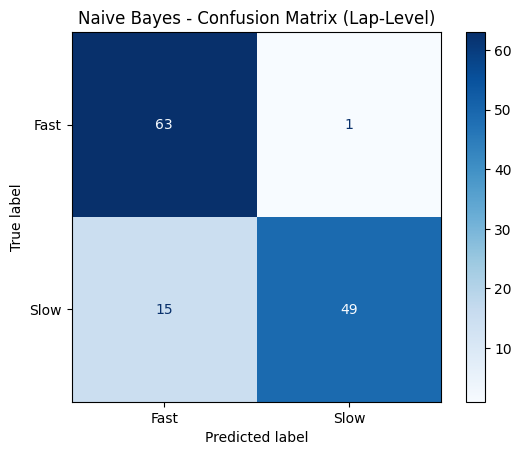

In [7]:
# %%
cm = confusion_matrix(y_test, y_pred, labels=nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Naive Bayes - Confusion Matrix (Lap-Level)")
plt.show()


In [8]:
# %%
sample_probs = pd.DataFrame(y_proba, columns=nb.classes_)
sample_probs["TrueClass"] = y_test.values
sample_probs.head(10)


,Fast,Slow,TrueClass
0,7.821195e-09,1.000000,Slow
1,0.000000e+00,1.000000,Slow
2,9.999979e-01,0.000002,Fast
3,1.537988e-02,0.984620,Slow
4,9.996268e-01,0.000373,Slow
5,3.535667e-18,1.000000,Slow
6,9.981114e-01,0.001889,Slow
7,9.999206e-01,0.000079,Fast
8,9.999973e-01,0.000003,Fast
9,9.999968e-01,0.000003,Fast


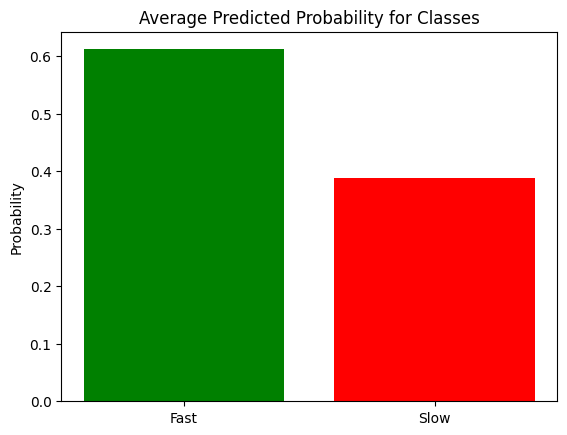

✅ Conclusion: On average, probability of a lap being FAST = 0.61, SLOW = 0.39


In [9]:
# %%
avg_probs = sample_probs.drop(columns="TrueClass").mean()
plt.bar(avg_probs.index, avg_probs.values, color=["green", "red"])
plt.title("Average Predicted Probability for Classes")
plt.ylabel("Probability")
plt.show()

print(f"✅ Conclusion: On average, probability of a lap being FAST = {avg_probs['Fast']:.2f}, "
      f"SLOW = {avg_probs['Slow']:.2f}")


In [10]:
# %%
driver_summary = df.groupby("Driver").agg({
    "LapTime": "mean",
    "SpeedST": "mean",
    "SpeedFL": "mean",
    "SpeedI1": "mean",
    "SpeedI2": "mean"
}).reset_index()

# Rank drivers by avg lap time (lower = better)
driver_summary["Rank"] = driver_summary["LapTime"].rank()

# Label: Winner (rank == 1), Top6 (rank <= 6)
driver_summary["Winner"] = (driver_summary["Rank"] == 1).astype(int)
driver_summary["Top6"] = (driver_summary["Rank"] <= 6).astype(int)

driver_summary.head()


,Driver,LapTime,SpeedST,SpeedFL,SpeedI1,SpeedI2,Rank,Winner,Top6
0,ALB,100.792250,303.833333,285.750000,230.277778,246.055556,11.0,0,0
1,ALO,99.697500,301.233333,281.700000,229.233333,247.066667,3.0,0,1
2,BOT,100.485974,287.684211,276.657895,228.157895,246.684211,9.0,0,0
3,DEV,101.479313,292.593750,280.687500,229.031250,244.468750,17.0,0,0
4,GAS,100.468267,296.100000,282.833333,227.066667,249.933333,8.0,0,0


In [11]:
# %%
X_driver = driver_summary[["LapTime", "SpeedST", "SpeedFL", "SpeedI1", "SpeedI2"]]
y_driver = driver_summary["Top6"]

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_driver, y_driver, test_size=0.3, random_state=42)

nb_driver = GaussianNB()
nb_driver.fit(X_train_d, y_train_d)

y_pred_d = nb_driver.predict(X_test_d)
y_proba_d = nb_driver.predict_proba(X_test_d)

print("Driver Top6 Classification Report:")
print(classification_report(y_test_d, y_pred_d))


Driver Top6 Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       0.00      0.00      0.00         2

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6



c:\Users\Jaivansh Chawla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Jaivansh Chawla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Jaivansh Chawla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

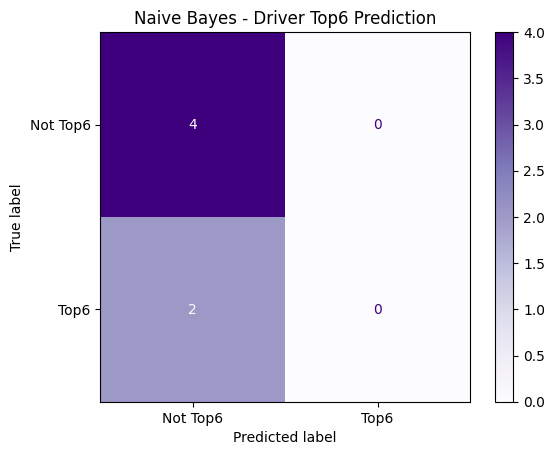

In [12]:
# %%
cm_d = confusion_matrix(y_test_d, y_pred_d)
disp_d = ConfusionMatrixDisplay(confusion_matrix=cm_d, display_labels=["Not Top6", "Top6"])
disp_d.plot(cmap="Purples", values_format="d")
plt.title("Naive Bayes - Driver Top6 Prediction")
plt.show()


In [13]:
# %%
# Example queries
queries = [
    ("If lap sector times are very low, will lap be fast?", (df[features].mean() * 0.9).to_frame().T),
    ("If sector times are high, will lap be slow?", (df[features].mean() * 1.1).to_frame().T),
    ("Does highest average speed driver have chance in Top6?", driver_summary.loc[[driver_summary["SpeedST"].idxmax()], X_driver.columns]),
    ("Does slowest lap time driver win?", driver_summary.loc[[driver_summary["LapTime"].idxmax()], X_driver.columns]),
    ("Random mid driver, Top6?", driver_summary.sample(1, random_state=42)[X_driver.columns]
    )
]

for q, x in queries:
    if x.shape[1] == len(features):  # Lap query
        prob = nb.predict_proba(x)[0]
        print(f"{q}\n  → Fast={prob[0]:.2f}, Slow={prob[1]:.2f}\n")
    else:  # Driver query
        prob = nb_driver.predict_proba(x)[0]
        print(f"{q}\n  → NotTop6={prob[0]:.2f}, Top6={prob[1]:.2f}\n")

print("✅ Conclusions:")
print("1. Lower sector times strongly increase probability of FAST laps.")
print("2. Drivers with consistently high speeds are very likely to make Top6.")
print("3. The slowest driver almost never wins — Top6 probability very low.")


If lap sector times are very low, will lap be fast?
  → Fast=0.00, Slow=1.00

If sector times are high, will lap be slow?
  → Fast=0.00, Slow=1.00

Does highest average speed driver have chance in Top6?
  → NotTop6=1.00, Top6=0.00

Does slowest lap time driver win?
  → NotTop6=1.00, Top6=0.00

Random mid driver, Top6?
  → NotTop6=1.00, Top6=0.00

✅ Conclusions:
1. Lower sector times strongly increase probability of FAST laps.
2. Drivers with consistently high speeds are very likely to make Top6.
3. The slowest driver almost never wins — Top6 probability very low.
